In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img1 = cv2.imread("assets/british-shorthair-9717301_640.jpg", cv2.IMREAD_GRAYSCALE)


In [2]:
#Escala

def escala(imagem, sx, sy):
    nova_altura = int(imagem.shape[0] * sy)
    nova_largura = int(imagem.shape[1] * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=imagem.dtype)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])

    for y in range(imagem.shape[0]):
        for x in range(imagem.shape[1]):
            ponto_original = np.array([x, y, 1])  
            novo_ponto = matriz_escala @ ponto_original
            novo_x = int(novo_ponto[0])
            novo_y = int(novo_ponto[1])
            if 0 <= novo_y < nova_altura and 0 <= novo_x < nova_largura:
                nova_imagem[novo_y, novo_x] = imagem[y, x]

    return nova_imagem


In [3]:
#Interpolação

def escala_interpolacao_vizinhoMaisProximo(imagem, sx, sy):
    altura, largura = imagem.shape
    nova_altura = int(altura * sy)
    nova_largura = int(largura * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=imagem.dtype)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])

    matriz_inversa = np.linalg.inv(matriz_escala)

    for y in range(nova_altura):
        for x in range(nova_largura):
            ponto = np.array([x, y, 1])
            ponto_original = matriz_inversa @ ponto
            orig_x = int(round(ponto_original[0]))
            orig_y = int(round(ponto_original[1]))
            if 0 <= orig_x < largura and 0 <= orig_y < altura:
                nova_imagem[y, x] = imagem[orig_y, orig_x]

    return nova_imagem

In [4]:
def cubic(p, x):
    """Função de interpolação cúbica para 4 pontos p e posição x (0 <= x <= 1)"""
    return (
        p[1] + 0.5 * x * (p[2] - p[0] +
        x * (2*p[0] - 5*p[1] + 4*p[2] - p[3] +
        x * (3*(p[1] - p[2]) + p[3] - p[0])))
    )

def get_pixel(imagem, x, y):
    """Evita acessar fora da imagem"""
    altura, largura = imagem.shape
    x = min(max(x, 0), largura - 1)
    y = min(max(y, 0), altura - 1)
    return float(imagem[y, x])

def escala_interpolacao_bicubica(imagem, sx, sy):
    altura, largura = imagem.shape
    nova_altura = int(altura * sy)
    nova_largura = int(largura * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=np.uint8)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])
    matriz_inversa = np.linalg.inv(matriz_escala)

    for y in range(nova_altura):
        for x in range(nova_largura):
            ponto = np.array([x, y, 1])
            ponto_original = matriz_inversa @ ponto
            orig_x, orig_y = ponto_original[0], ponto_original[1]

            x_base = int(np.floor(orig_x))
            y_base = int(np.floor(orig_y))
            dx = orig_x - x_base
            dy = orig_y - y_base

            # Coletar os 4x4 pixels
            valores = []
            for m in range(-1, 3):  # 4 linhas
                linha = []
                for n in range(-1, 3):  # 4 colunas
                    linha.append(get_pixel(imagem, x_base + n, y_base + m))
                valores.append(linha)

            # Interpola nas colunas (horizontal)
            colunas_interpoladas = [cubic(valores[i], dx) for i in range(4)]

            # Interpola nas linhas (vertical)
            valor_final = cubic(colunas_interpoladas, dy)

            # Clampa o valor para 0-255
            nova_imagem[y, x] = np.clip(valor_final, 0, 255)

    return nova_imagem


In [5]:
sx, sy = 2, 2
img_escala = escala(img1, sx, sy)
img_vizinho = escala_interpolacao_vizinhoMaisProximo(img1, sx, sy)
img_bicubica = escala_interpolacao_bicubica(img1, sx, sy)

#Recorte para Zoom 
tamanho = 150
altura, largura = img1.shape

#Coordenadas 
x0 = (largura - tamanho) // 2
y0 = (altura - tamanho) // 2
recorte_x = tamanho
recorte_y = tamanho

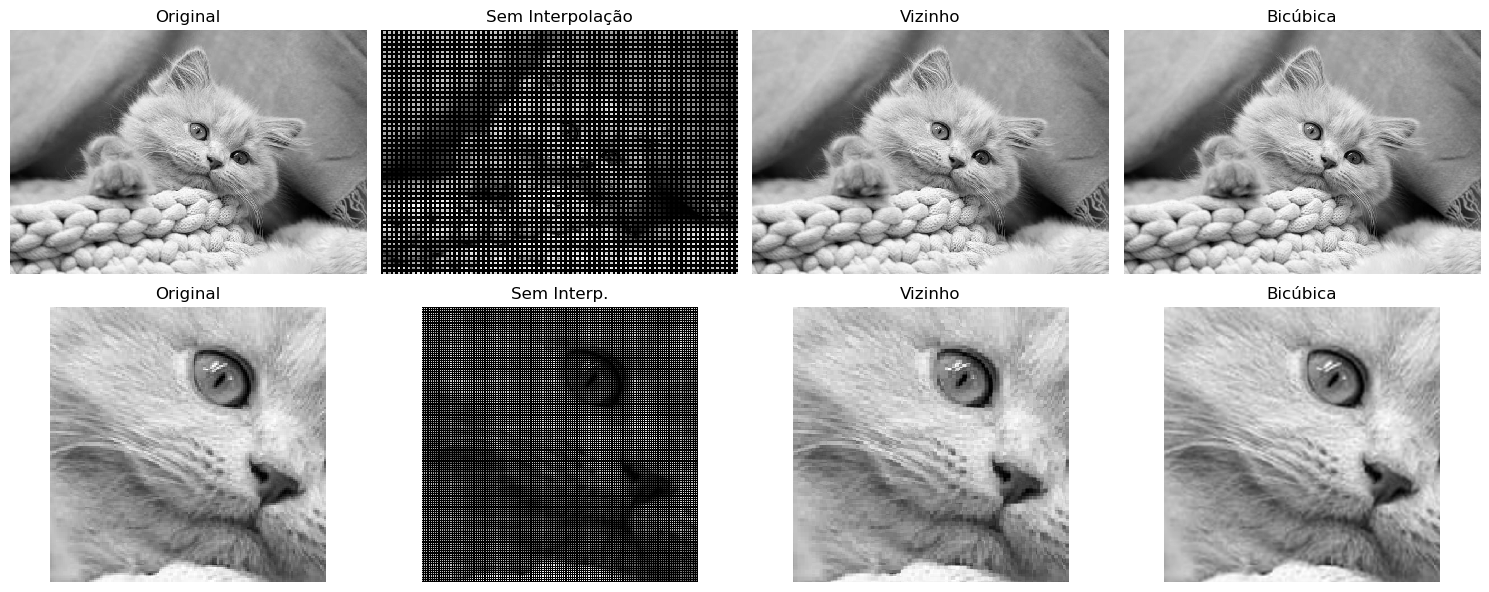

In [6]:
plt.figure(figsize=(15, 6))

#Original
plt.subplot(2, 4, 1)
plt.imshow(img1, cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

#Escala direta
plt.subplot(2, 4, 2)
plt.imshow(img_escala, cmap='gray', interpolation='none')
plt.title("Sem Interpolação")
plt.axis('off')

#Vizinho
plt.subplot(2, 4, 3)
plt.imshow(img_vizinho, cmap='gray', interpolation='none')
plt.title("Vizinho")
plt.axis('off')

#Bicúbica
plt.subplot(2, 4, 4)
plt.imshow(img_bicubica, cmap='gray', interpolation='none')
plt.title("Bicúbica")
plt.axis('off')

#Recortes
plt.subplot(2, 4, 5)
plt.imshow(img1[y0:y0+recorte_y, x0:x0+recorte_x], cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(img_escala[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Sem Interp.")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(img_vizinho[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Vizinho")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(img_bicubica[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Bicúbica")
plt.axis('off')

plt.tight_layout()
plt.show()